In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import os
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

train_df = pd.read_csv('/home/charlemagne/workspace/kaggle_challenge_titanic/data/train.csv')
test_df = pd.read_csv('/home/charlemagne/workspace/kaggle_challenge_titanic/data/test.csv')
submission_file_path = '/home/charlemagne/workspace/kaggle_challenge_titanic/submission/submission.csv'

def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train_df = preprocess(train_df)
preprocessed_test_df = preprocess(test_df)

input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")

def tokenize_names(features, labels=None):
    features["Name"] = tf.strings.split(features["Name"])
    return features, labels

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train_df, label="Survived").map(tokenize_names)
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_test_df).map(tokenize_names)

num_trees = 300
min_examples = 5
categorical_algorithm = "CART"

model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=1234,
    num_trees=num_trees,
    min_examples=min_examples,
    categorical_algorithm=categorical_algorithm
)
model.fit(train_ds)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

def prediction_to_kaggle_format(model, threshold=0.5):
    proba_survive = model.predict(serving_ds, verbose=0)[:, 0]
    return pd.DataFrame({
        "PassengerId": preprocessed_test_df["PassengerId"],
        "Survived": (proba_survive >= threshold).astype(int)
    })

kaggle_predictions = prediction_to_kaggle_format(model)
kaggle_predictions.to_csv(submission_file_path, index=False)
print(f"Submission exported to {submission_file_path}")

tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization", ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=0)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

[WARNING 24-02-21 10:20:58.5764 CET gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-21 10:20:58.5764 CET gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-21 10:20:58.5764 CET gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Accuracy: 0.8260869383811951 Loss:0.8608942627906799
Submission exported to /home/charlemagne/workspace/kaggle_challenge_titanic/submission/submission.csv
Use /tmp/tmpl_rwj2oj as temporary training directory


[INFO 24-02-21 10:20:58.8237 CET kernel.cc:1233] Loading model from path /tmp/tmp1kap5lp4/model/ with prefix 490c41b4f5164e3b
[INFO 24-02-21 10:20:58.8249 CET quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-21 10:20:58.8250 CET abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-21 10:20:58.8251 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-02-21 10:20:58.9925 CET gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-21 10:20:58.9926 CET gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-21 10:20:58.9926 CET gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Accuracy: 0.8630136847496033 Loss:0.6749962568283081


[INFO 24-02-21 10:21:11.3303 CET kernel.cc:1233] Loading model from path /tmp/tmpl_rwj2oj/model/ with prefix 722e2cf556bd4ebf
[INFO 24-02-21 10:21:11.3352 CET decision_forest.cc:660] Model loaded with 30 root(s), 2236 node(s), and 12 input feature(s).
[INFO 24-02-21 10:21:11.3352 CET abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-02-21 10:21:11.3353 CET kernel.cc:1061] Use fast generic engine


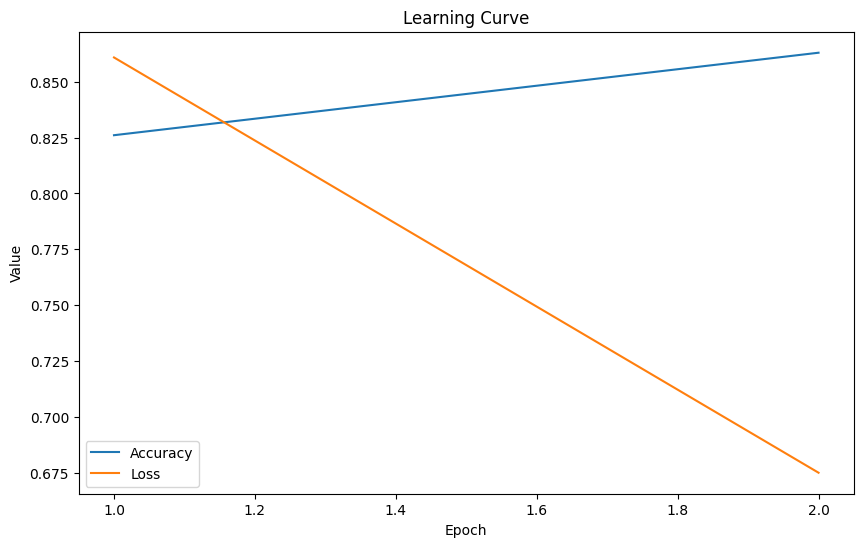

In [6]:
import matplotlib.pyplot as plt

def plot_learning_curve(evaluation_results, title='Learning Curve'):
    epochs = range(1, len(evaluation_results['accuracy']) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, evaluation_results['accuracy'], label='Accuracy')
    plt.plot(epochs, evaluation_results['loss'], label='Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

evaluation_results = {
    'accuracy': [self_evaluation.accuracy, tuned_self_evaluation.accuracy],
    'loss': [self_evaluation.loss, tuned_self_evaluation.loss] 
}

plot_learning_curve(evaluation_results)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

def evaluate_model(model, test_ds):
    predictions = model.predict(test_ds, verbose=0)[:, 0]
    binary_predictions = (predictions >= 0.5).astype(int)
    labels = np.concatenate([y for x, y in test_ds], axis=0)
    
    accuracy = accuracy_score(labels, binary_predictions)
    roc_auc = roc_auc_score(labels, predictions)
    f1 = f1_score(labels, binary_predictions)
    tn, fp, fn, tp = confusion_matrix(labels, binary_predictions).ravel()
    specificity = tn / (tn + fp)
    
    metrics = {
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "F1 Score": f1,
        "Specificity": specificity
    }
    return metrics

print(" métriques avant amélioration :")
metrics_untuned = evaluate_model(model, train_ds)
for metric, value in metrics_untuned.items():
    print(f"{metric}: {value}")

print("\n métriques après améliorations :")
metrics_tuned = evaluate_model(tuned_model, train_ds)
for metric, value in metrics_tuned.items():
    print(f"{metric}: {value}")

 métriques avant amélioration :
Accuracy: 0.8967452300785634
ROC AUC: 0.9537276707250822
F1 Score: 0.8571428571428571
Specificity: 0.9526411657559198

 métriques après améliorations :
Accuracy: 0.9382716049382716
ROC AUC: 0.9850552306692658
F1 Score: 0.9162861491628616
Specificity: 0.9744990892531876
